In [362]:
import pandas as pd
import tsfresh as tsf
from tsfresh.feature_extraction import settings
from pathlib import Path
import pycatch22
import numpy as np

import matplotlib as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import linregress
from scipy.fft import fft, fftfreq
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## Dataset with scores

In [207]:
df = pd.read_csv('data\local_global_res_13_12.csv')

In [208]:
df

,Unnamed: 0.1,Unnamed: 0,train_time,forecast_time,MAE,MSE,RMSE,MASE,RMSSE,MAPE,SMAPE,naming_orig,model_name,dataset_name,horizon,split,pred_time
0,0,0.0,3.812914,4.442261,18.260277,619.323792,24.886217,0.896638,0.792087,inf,16.386864,danish_atm_daily_5,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
1,1,0.0,3.485261,4.376619,28.395468,1160.189331,34.061552,1.088141,0.918072,41.157335,17.157184,danish_atm_daily_84,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
2,2,0.0,3.812914,4.442261,12.825266,269.356567,16.412086,0.814535,0.757765,39.022604,13.038494,danish_atm_daily_32,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,test,NaN
3,3,0.0,3.485261,4.376619,26.284388,1121.348877,33.486548,0.918232,0.792925,57.078475,18.962322,danish_atm_daily_25,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
4,4,0.0,3.485261,4.376619,15.145726,429.357697,20.720948,0.663444,0.597604,21.996029,10.027625,danish_atm_daily_6,CatBoostAutoRegressivePipelineEtna_3lags_gl,danish_atm_daily,30,validation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36449,0,NaN,225.815618,1.806664,2.762839,11.352131,3.369292,0.779592,0.688223,20.044580,8.785076,nn5_98,DeepARTuningObjective,nn5,30,validation,NaN
36450,0,NaN,221.914140,1.835336,2.712137,16.868277,4.107101,0.679580,0.778644,29.559124,10.474208,nn5_99,DeepARTuningObjective,nn5,30,test,NaN
36451,0,NaN,225.815618,1.806664,1.519503,3.326512,1.823873,0.381234,0.345513,11.370875,5.622922,nn5_99,DeepARTuningObjective,nn5,30,validation,NaN
36452,0,NaN,221.914140,1.835336,3.380999,22.316181,4.724001,0.658609,0.684295,23.539458,8.428656,nn5_9,DeepARTuningObjective,nn5,30,test,NaN


In [209]:
df['naming_orig'].value_counts()

naming_orig
mipt_alpha_193    44
mipt_alpha_342    44
mipt_alpha_510    44
mipt_alpha_151    44
mipt_alpha_584    44
                  ..
nn5_23            34
nn5_2             34
nn5_50            34
nn5_111            6
nn5_112            6
Name: count, Length: 876, dtype: int64

## Analyzing the time-series

In [5]:
input_dir = Path.cwd() / 'time_series'
folders = list(input_dir.glob("*"))


In [6]:
# Calcualtion of the initial time-series value counts

ts_full = pd.DataFrame()

for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        time_series = pd.read_csv(path)
        time_series['naming_orig'] = path.stem
        ts_full = pd.concat([ts_full, time_series])

ts_full.shape[0]

544221

All time-series has 544221 values initially

In [7]:
li1 = list(df['naming_orig'].unique())
li2 = list(ts_full['naming_orig'].unique())
temp3 = []
for element in li1:
    if element not in li2:
        temp3.append(element)
 
print(temp3)

['nn5_112', 'nn5_111']


Also `nn5_112`, `nn5_111` time-series dropped, because they presented only in dataset with scores

In [8]:
# Dropping of last 60 days

ts = pd.DataFrame()
ts_list = []

for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        time_series = pd.read_csv(path)
        if time_series.shape[0] > 60:
            time_series = time_series[:-60]
            time_series['naming_orig'] = path.stem
            ts = pd.concat([ts, time_series])
            ts_list.append(path.stem)

ts.shape[0]

491866

After droping last 60 days all time-series has 491866 values

In [9]:
# Finding such time-series that has less than 60 days

for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        time_series = pd.read_csv(path)
        if time_series.shape[0] < 60:
            print(f'{path.stem} leghts: {time_series.shape[0]}')

danish_atm_daily_110 leghts: 42
danish_atm_daily_111 leghts: 28
danish_atm_daily_112 leghts: 25


This 3 dropped from the consideration, because it has less than 60 days

In [307]:
df_for_split = pd.DataFrame(columns=['dataset_name', 'naming_orig'])

for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        if pd.read_csv(path).shape[0] > 60:
            df_for_split.loc[len(df_for_split.index)] = [folder.stem, path.stem]

Train_df, Holdout, _, _ = train_test_split(df_for_split['naming_orig'], df_for_split['dataset_name'], test_size=0.3, stratify=df_for_split['dataset_name'], random_state=42)
test_list = Holdout.to_list()
train_list = Train_df.to_list()

## Combination of all feature extraction methods together

In [345]:
def extract_time_series_features(dataset):
    # Reformat 'date' column to datetime and setting it as index
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset.set_index('date', inplace=True)
    
    # Using of 'value' column as time-series
    time_series = dataset['value']
    
    # Initialization of fetures' dictionary
    features = {}
    
    # Time fetures of time series
    features['trend_slope'], _, _, _, _ = linregress(np.arange(len(time_series)), time_series)
    acf_values = acf(time_series, nlags=24, fft=True)
    features['seasonality_strength'] = np.max(acf_values[1:])
    features['num_peaks'] = len(find_peaks(time_series)[0])
    features['diff_mean'] = time_series.diff().mean()
    features['diff_std'] = time_series.diff().std()
    zcr = ((time_series[:-1] * time_series[1:]) < 0).sum()
    features['zero_crossing_rate'] = zcr
    
    # Spectral fetures
    fft_vals = fft(time_series.to_numpy())
    fft_freq = fftfreq(len(fft_vals), d=1)
    dominant_freq = fft_freq[np.argmax(np.abs(fft_vals)**2)]
    features['dominant_freq'] = np.abs(dominant_freq)
    significant_freqs = np.sum(np.abs(fft_vals)**2 > 1e-5)
    features['significant_freqs'] = significant_freqs
    for freq in range(1, 6):
        freq_mask = (fft_freq >= freq - 0.5) & (fft_freq <= freq + 0.5)
        features[f'fft_energy_freq_{freq}'] = np.sum(np.abs(fft_vals[freq_mask])**2)
    
    # Morphological fetures
    peaks, _ = find_peaks(time_series)
    peak_distances = np.diff(peaks)
    features['mean_peak_distance'] = np.mean(peak_distances) if len(peak_distances) > 0 else 0
    features['std_peak_distance'] = np.std(peak_distances) if len(peak_distances) > 0 else 0
    peak_heights = time_series.iloc[peaks]
    features['mean_peak_height'] = peak_heights.mean()
    features['std_peak_height'] = peak_heights.std()
    
    # Additional features
    extrema = np.diff(np.sort(np.concatenate([find_peaks(time_series)[0], find_peaks(-time_series)[0]])))
    features['mean_extrema_diff'] = np.mean(extrema) if len(extrema) > 0 else 0
    features['std_extrema_diff'] = np.std(extrema) if len(extrema) > 0 else 0
    curvature = np.diff(time_series, n=2).mean()
    features['mean_curvature'] = curvature
    magnitude = np.abs(fft_vals)
    normalized_magnitude = magnitude / np.sum(magnitude)
    signal_entropy = -np.sum(normalized_magnitude * np.log(normalized_magnitude + np.finfo(float).eps))
    features['signal_entropy'] = signal_entropy
    total_energy = np.sum(np.square(time_series))
    features['total_energy'] = total_energy
    features['diff_skew'] = skew(time_series.diff().dropna())
    features['diff_kurt'] = kurtosis(time_series.diff().dropna())
    features['time_series_length'] = len(time_series)
    features['mae_diff'] = np.mean(np.abs(time_series.diff().dropna()))
    
    return features

In [346]:
ts = pd.DataFrame()

tsData = pd.read_csv('time_series\mipt_alpha\mipt_alpha_0.csv', index_col=0)
pycatch22.CO_f1ecac(list(tsData['value']))


# Initialization of the Catch22 and our own featurs dataframes
catch22_df = pd.DataFrame(columns=pycatch22.catch22_all(list(tsData['value']), catch24=True)['names'])
ord_features_df = pd.DataFrame(columns=list(extract_time_series_features(tsData).keys()))

# Calculation of Catch22 and our own features across all time-series (last 60 days did not used)
for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        time_series = pd.read_csv(path)
        if time_series.shape[0] > 60:
            time_series = time_series[:-60]
            time_series['naming_orig'] = path.stem
            ts = pd.concat([ts, time_series])
            pycatch22.CO_f1ecac(list(time_series['value']))
            catch22_df.loc[len(catch22_df.index)] = pycatch22.catch22_all(list(time_series['value']),catch24=True)['values']
            ord_features_df.loc[len(ord_features_df.index)] = list(extract_time_series_features(time_series).values())

# Calculation of tsfresh features
tsf_df = tsf.extract_features(ts, column_id='naming_orig', 
                              column_sort="date", column_value='value').rename_axis('naming_orig').reset_index()

# Combinig of all datasets to one
all_features = pd.concat([tsf_df, catch22_df, ord_features_df], axis=1)

Feature Extraction: 100%|██████████| 40/40 [00:46<00:00,  1.15s/it]


In [347]:
for column in all_features.columns:
  if (all_features[column].isna().sum()>100) or (all_features[column].nunique() < 2):
    all_features.drop([column], axis=1,  inplace=True)

all_features.replace([np.inf, -np.inf], np.nan, inplace=True)
all_features.fillna(0, inplace=True)

In [348]:
all_features

,naming_orig,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,std_peak_height,mean_extrema_diff,std_extrema_diff,mean_curvature,signal_entropy,total_energy,diff_skew,diff_kurt,time_series_length,mae_diff
0,danish_atm_daily_0,0.0,1.0,1.0,35327.000000,4.805377e+06,35.180921,0.398026,-0.287129,112.000000,...,53.571178,1.750000,0.807847,-0.574257,5.100711,4.805377e+06,0.141664,5.759565,305.0,35.180921
1,danish_atm_daily_1,0.0,1.0,1.0,25074.000000,3.597174e+06,35.873096,-0.015228,0.443878,123.500000,...,49.935416,1.710526,0.834809,0.887755,4.574701,3.597174e+06,0.406797,3.227857,198.0,35.873096
2,danish_atm_daily_10,0.0,1.0,1.0,27172.000000,3.278432e+06,31.470395,0.319079,-0.206271,83.000000,...,70.440769,1.935897,1.217814,-0.412541,5.294722,3.278432e+06,1.406318,8.212164,305.0,31.470395
3,danish_atm_daily_100,0.0,1.0,1.0,12234.000000,6.264840e+05,18.096346,-0.016611,-0.010000,38.000000,...,21.974311,1.728324,0.826691,-0.020000,5.210385,6.264840e+05,-0.076666,2.179983,302.0,18.096346
4,danish_atm_daily_101,0.0,1.0,1.0,13813.000000,1.375921e+06,34.407821,-0.217877,-0.081461,72.000000,...,45.951714,1.712871,0.871287,-0.162921,4.689043,1.375921e+06,0.136356,2.367263,180.0,34.407821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,nn5_95,0.0,1.0,1.0,15562.835350,3.864449e+05,7.733223,0.012809,0.006494,20.305103,...,7.677542,1.766990,0.872491,0.012989,5.944508,3.864449e+05,-0.730954,1.531685,731.0,7.733223
867,nn5_96,0.0,1.0,1.0,9925.473435,1.695436e+05,5.359904,0.002342,0.004672,12.809048,...,6.711614,1.647059,0.750477,0.009345,5.990598,1.695436e+05,0.087705,1.590454,731.0,5.359904
868,nn5_97,0.0,1.0,1.0,14966.333509,3.548706e+05,7.519889,0.005747,-0.001813,19.029458,...,8.155347,1.615213,1.025204,-0.003626,5.929239,3.548706e+05,-0.586895,1.892068,731.0,7.519889
869,nn5_98,0.0,1.0,1.0,10153.037875,1.618989e+05,3.804162,0.010052,0.004339,13.216728,...,5.250554,2.275000,1.249750,0.008677,5.920899,1.618989e+05,-0.488383,2.809081,731.0,3.804162


## Tsfresh feature extraction separately

In [300]:
tsf_features = tsf.extract_features(ts, column_id='naming_orig', column_sort="date", column_value='value').rename_axis('naming_orig').reset_index()

Feature Extraction: 100%|██████████| 40/40 [00:42<00:00,  1.06s/it]


In [301]:
for column in tsf_features.columns:
  if (tsf_features[column].isna().sum()>100) or (tsf_features[column].nunique() < 2):
    tsf_features.drop([column], axis=1,  inplace=True)

tsf_features.replace([np.inf, -np.inf], np.nan, inplace=True)
tsf_features.fillna(0, inplace=True)

In [302]:
tsf_features

,naming_orig,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__mean_n_absolute_max__number_of_maxima_7
0,danish_atm_daily_0,0.0,1.0,1.0,35327.000000,4.805377e+06,35.180921,0.398026,-0.287129,112.000000,...,0.190068,0.421225,0.789363,2.622601,1.767971,3.034560,4.375074,5.263476,5.615238,297.142857
1,danish_atm_daily_1,0.0,1.0,1.0,25074.000000,3.597174e+06,35.873096,-0.015228,0.443878,123.500000,...,0.359824,0.543010,0.874213,2.813297,1.769858,3.052773,4.320155,4.971714,5.163632,270.857143
2,danish_atm_daily_10,0.0,1.0,1.0,27172.000000,3.278432e+06,31.470395,0.319079,-0.206271,83.000000,...,0.388986,0.709455,1.325598,3.270304,1.743287,3.022493,4.312761,5.200817,5.553737,310.142857
3,danish_atm_daily_100,0.0,1.0,1.0,12234.000000,6.264840e+05,18.096346,-0.016611,-0.010000,38.000000,...,0.273505,0.518430,1.012266,3.075171,1.766600,3.070894,4.390954,5.274696,5.582021,113.857143
4,danish_atm_daily_101,0.0,1.0,1.0,13813.000000,1.375921e+06,34.407821,-0.217877,-0.081461,72.000000,...,0.543192,0.904650,1.520827,3.400283,1.756908,3.068501,4.231227,4.913234,5.100278,208.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,nn5_95,0.0,1.0,1.0,15562.835350,3.864449e+05,7.733223,0.012809,0.006494,20.305103,...,0.155665,0.220352,0.359290,1.728504,1.720757,2.875198,3.905096,4.791921,5.545824,44.348839
867,nn5_96,0.0,1.0,1.0,9925.473435,1.695436e+05,5.359904,0.002342,0.004672,12.809048,...,0.159721,0.299054,0.486589,1.980298,1.770813,3.083749,4.447584,5.536191,6.175557,35.881491
868,nn5_97,0.0,1.0,1.0,14966.333509,3.548706e+05,7.519889,0.005747,-0.001813,19.029458,...,0.155665,0.235155,0.386685,1.935132,1.701948,2.882123,4.067925,5.049872,5.801435,46.462388
869,nn5_98,0.0,1.0,1.0,10153.037875,1.618989e+05,3.804162,0.010052,0.004339,13.216728,...,0.079983,0.159721,0.379592,2.064913,1.679283,2.861425,4.105197,5.200904,5.959706,35.438115


## Catch22 feature extraction separately

In [11]:
tsData = list(pd.read_csv('time_series\mipt_alpha\mipt_alpha_0.csv')['value'])
pycatch22.CO_f1ecac(tsData)

catch22_features_names = pycatch22.catch22_all(tsData,catch24=True)['names']
catch22_features_names.append('naming_orig')
catch22_features = pd.DataFrame(columns=catch22_features_names)

In [12]:
for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        tsData = list(pd.read_csv(path)['value'])
        if len(tsData) > 60:
            tsData = tsData[:-60]
            pycatch22.CO_f1ecac(tsData)
            values = pycatch22.catch22_all(tsData,catch24=True)['values']
            values.append(path.stem)
            catch22_features.loc[len(catch22_features.index)] = values

In [13]:
catch22_features

,DN_HistogramMode_5,DN_HistogramMode_10,CO_f1ecac,CO_FirstMin_ac,CO_HistogramAMI_even_2_5,CO_trev_1_num,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01,...,SP_Summaries_welch_rect_area_5_1,SB_BinaryStats_diff_longstretch0,SB_MotifThree_quantile_hh,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SP_Summaries_welch_rect_centroid,FC_LocalSimple_mean3_stderr,DN_Mean,DN_Spread_Std,naming_orig
0,-0.359681,-0.021182,0.997249,5,0.047562,0.230615,0.953947,11.0,0.007329,6,...,0.362087,5.0,2.144503,0.272727,0.750000,0.895845,1.087345,115.826230,48.449098,danish_atm_daily_0
1,-0.668499,-0.323838,0.986372,2,0.077838,0.588997,0.974619,12.0,0.001701,6,...,0.267334,5.0,2.122243,0.523810,0.857143,0.908117,1.112832,126.636364,46.277349,danish_atm_daily_1
2,0.254371,-0.067559,1.283223,5,0.088714,1.728943,0.858553,12.0,0.006428,6,...,0.433361,6.0,2.098486,0.204545,0.795455,0.822214,1.027686,89.088525,53.117255,danish_atm_daily_10
3,0.200936,-0.156331,0.888612,2,0.026275,-0.132719,0.950166,7.0,0.001600,3,...,0.291477,5.0,2.143882,0.318182,0.795455,0.908117,1.125376,40.509934,20.852708,danish_atm_daily_100
4,-0.005686,-0.309176,0.915056,2,0.051820,0.199214,0.944134,9.0,0.013602,2,...,0.284574,6.0,2.163185,0.341463,0.829268,0.908117,1.099711,76.738889,42.011353,danish_atm_daily_101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,-0.848734,-0.581828,0.839706,2,0.071229,-1.342511,0.964384,14.0,0.004909,6,...,0.207425,5.0,2.092087,0.340426,0.127660,0.901981,1.155091,21.289788,8.689107,nn5_95
867,0.057987,-0.279549,1.556406,2,0.090564,0.104026,0.961644,41.0,0.017778,2,...,0.484445,5.0,2.102796,0.297872,0.872340,0.668816,0.927924,13.577939,6.902063,nn5_96
868,-0.500446,-0.165014,0.745356,3,0.048434,-1.291514,0.958904,7.0,0.008422,6,...,0.161463,4.0,2.104722,0.191489,0.851064,1.043107,1.186160,20.473780,8.147034,nn5_97
869,-0.076320,-0.496427,1.314550,4,0.042183,-0.489283,0.945205,12.0,0.005143,6,...,0.339475,6.0,2.088743,0.127660,0.851064,0.895845,1.112042,13.889245,5.348268,nn5_98


## Ordinary features separately

In [274]:
tsData = pd.read_csv('time_series\mipt_alpha\mipt_alpha_0.csv', index_col=0)

features = list(extract_time_series_features(tsData).keys())
features.append('naming_orig')
ord_features = pd.DataFrame(columns=features)


for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        tsData = pd.read_csv(path, index_col=0)
        if tsData.shape[0] > 60:
            tsData = tsData[:-60]
            values = list(extract_time_series_features(tsData).values())
            values.append(path.stem)
            ord_features.loc[len(ord_features.index)] = values

In [275]:
for column in ord_features.columns:
  if (ord_features[column].nunique() < 2):
    ord_features.drop([column], axis=1,  inplace=True)

ord_features.replace([np.inf, -np.inf], np.nan, inplace=True)
ord_features.fillna(0, inplace=True)

In [276]:
ord_features

,trend_slope,seasonality_strength,num_peaks,diff_mean,diff_std,significant_freqs,mean_peak_distance,std_peak_distance,mean_peak_height,std_peak_height,mean_extrema_diff,std_extrema_diff,mean_curvature,signal_entropy,total_energy,diff_skew,diff_kurt,time_series_length,mae_diff,naming_orig
0,0.015819,0.366136,87,0.398026,54.407727,305,3.500000,1.255222,151.402299,53.571178,1.750000,0.807847,-0.574257,5.100711,4.805377e+06,0.141664,5.759565,305,35.180921,danish_atm_daily_0
1,0.161503,0.359146,57,-0.015228,52.524579,198,3.392857,1.160027,159.245614,49.935416,1.710526,0.834809,0.887755,4.574701,3.597174e+06,0.406797,3.227857,198,35.873096,danish_atm_daily_1
2,-0.024434,0.426753,79,0.319079,56.770398,305,3.871795,1.930584,127.367089,70.440769,1.935897,1.217814,-0.412541,5.294722,3.278432e+06,1.406318,8.212164,305,31.470395,danish_atm_daily_10
3,-0.002469,0.288642,87,-0.016611,24.864896,302,3.465116,1.138110,56.781609,21.974311,1.728324,0.826691,-0.020000,5.210385,6.264840e+05,-0.076666,2.179983,302,18.096346,danish_atm_daily_100
4,0.167296,0.309200,51,-0.217877,49.461283,180,3.440000,1.344024,109.000000,45.951714,1.712871,0.871287,-0.162921,4.689043,1.375921e+06,0.136356,2.367263,180,34.407821,danish_atm_daily_101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,0.002568,0.604370,206,0.012809,10.665908,731,3.531707,1.111018,27.463062,7.677542,1.766990,0.872491,0.012989,5.944508,3.864449e+05,-0.730954,1.531685,731,7.733223,nn5_95
867,-0.004827,0.575306,221,0.002342,7.284462,731,3.286364,0.946186,17.665982,6.711614,1.647059,0.750477,0.009345,5.990598,1.695436e+05,0.087705,1.590454,731,5.359904,nn5_96
868,-0.002984,0.587006,224,0.005747,10.613978,731,3.233184,1.391638,26.535905,8.155347,1.615213,1.025204,-0.003626,5.929239,3.548706e+05,-0.586895,1.892068,731,7.519889,nn5_97
869,0.005759,0.494742,160,0.010052,5.375899,731,4.540881,1.902472,18.195111,5.250554,2.275000,1.249750,0.008677,5.920899,1.618989e+05,-0.488383,2.809081,731,3.804162,nn5_98


## Feature Selection

In [210]:
df_for_split = pd.DataFrame(columns=['dataset_name', 'naming_orig'])

for folder in folders:
    paths = list(folder.glob("*"))
    for path in paths:
        if pd.read_csv(path).shape[0] > 60:
            df_for_split.loc[len(df_for_split.index)] = [folder.stem, path.stem]

Train_df, Holdout, _, _ = train_test_split(df_for_split['naming_orig'], df_for_split['dataset_name'], test_size=0.3, stratify=df_for_split['dataset_name'], random_state=42)
test_list = Holdout.to_list()
train_list = Train_df.to_list()

This cocde provides splitting into train and holdout parts with stratification (to make `dataset_name` distribution equal for `Train_df`, `Holdout`)

In [211]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,  inplace=True)

In [212]:
df = df[df['SMAPE'].notna()]
df = df[df['split'] == 'validation']
df = df[(df['naming_orig'] != 'danish_atm_daily_110')&(df['naming_orig'] != 'danish_atm_daily_111')&(df['naming_orig'] != 'danish_atm_daily_112')]
df = df[(df['model_name']!= 'TFTTuningObjective')&(df['model_name']!= 'DeepARTuningObjective')]
df = df[(df['model_name']!= 'TFTTuningObjective')&(df['model_name']!= 'DeepARTuningObjective')]
df.drop(['split', 'horizon',  'RMSE', 'RMSSE', 'MSE', 'MASE', 'MAE',
       'MAPE','dataset_name','pred_time'], axis=1,  inplace=True)

In [213]:
best_model_df = df.groupby('naming_orig').apply(lambda x: x.loc[x['SMAPE'].idxmin()][['naming_orig','model_name']])
best_model_df.reset_index(drop= True , inplace= True )
best_model_df['model_name'].value_counts()

model_name
TFTTuningObjective_gl                                159
LightAutoML_mult_gl                                   89
Prophet                                               83
LightAutoML                                           80
CatBoostDirectPipelineEtna_horizonlags_gl             73
NeuralProphet                                         72
CatBoostAutoRegressivePipelineEtna_horizonlags        68
DeepARTuningObjective_gl                              52
CatBoostAutoRegressivePipelineEtna_horizonlags_gl     51
CatBoostDirectPipelineEtna_horizonlags                50
LSTNetTuningObjective_gl                              37
NeuralProphet_gl                                      20
ARIMAEtna                                             12
CatBoostAutoRegressivePipelineEtna_3lags_gl            9
OLS                                                    6
BaselineMean                                           4
CatBoostDirectPipelineEtna_3lags                       4
CatBoostAutoRegressi

### Features selection by RandomForest feature importance

In [378]:
df_merged_all = pd.merge(all_features, best_model_df)

encoder = LabelEncoder()
df_merged_all['model_id'] = encoder.fit_transform(df_merged_all[['model_name']])
features = all_features.drop('naming_orig', axis=1).columns

df_merged_all_train = df_merged_all[df_merged_all['naming_orig'].isin(list(Train_df))]

y_train = df_merged_all_train['model_id'] # labels of the best model for each time series
x_train = df_merged_all_train[features] # all features for each time-series

clf = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth=5)
clf.fit(x_train, y_train)
clf_dictionary = dict(zip(clf.feature_names_in_[:-1], clf.feature_importances_))
clf_sorted_dictionary = sorted(clf_dictionary.items(), key=lambda x: x[1])
clf_features = [i[0] for i in clf_sorted_dictionary]
clf_values = [i[1] for i in clf_sorted_dictionary]

In [393]:
cv = 10
scores_list = []
num_best_features = [5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 400, 500]

for n in num_best_features:

    best_features = clf_features[-n:]
    best_features.append('naming_orig')
    scores = []

    X_train = df_merged_all.drop(['model_id', 'model_name'], axis=1)[best_features]
    y_train = df_merged_all['model_id']

    for i in range(cv):
        X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=i+1)
    
        clf = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth=5)
        clf.fit(X_train_cv.drop('naming_orig', axis=1), y_train_cv)
        y_pred = clf.predict(X_val_cv.drop('naming_orig', axis=1))

        errors = 0
        sum = 0
        for series, model_id in zip(X_val_cv['naming_orig'].to_list(), y_pred):
            try:
                sum+=df[(df['naming_orig'] == series)&(df['model_name'] == encoder.classes_[model_id])]['SMAPE'].to_list()[0]
            except IndexError:
                errors+=1

        scores.append(sum/(X_val_cv.shape[0] - errors))
       
    scores_list.append(np.mean(scores))

In [400]:
min(scores_list)

21.670094709184276

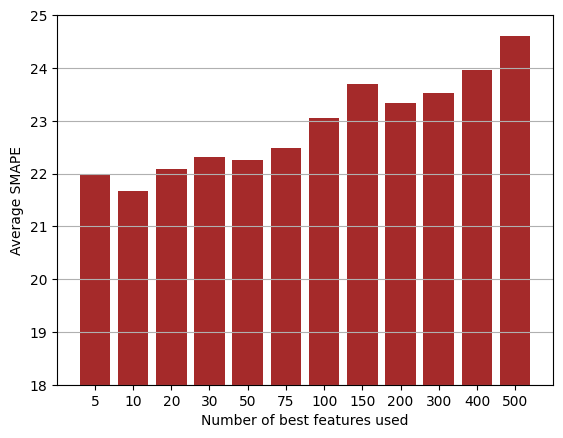

In [395]:
plt.bar([str(x) for x in num_best_features], scores_list, color='brown')
plt.ylim([18, 25])
plt.xlabel('Number of best features used')
plt.ylabel('Average SMAPE')
plt.grid(axis='y')

### Ordinary feature selection by forward search

In [289]:
df_merged_ord = pd.merge(ord_features, best_model_df)

encoder = LabelEncoder()
df_merged_ord['model_id'] = encoder.fit_transform(df_merged_ord[['model_name']])
features = ord_features.drop('naming_orig', axis=1).columns

df_merged_ord_train = df_merged_ord[df_merged_ord['naming_orig'].isin(list(Train_df))]

In [291]:
def scoring(model, used_features, cv = 5):
    scores = []
    y_true = df_merged_ord_train['model_id']
    x_class = df_merged_ord_train[used_features]
    for i in range(cv):
      x_clf_train, x_clf_test, y_clf_train, y_clf_test = train_test_split(x_class, y_true, test_size = 0.3, shuffle = True, random_state=i)
      model.fit(x_clf_train, y_clf_train)
      y_clf_pred = model.predict(x_clf_test)
      errors = 0
      sum = 0
      for num, idx in enumerate(x_clf_test.index):
        try:
          sum+=df[(df['naming_orig'] == df_merged_ord_train.iloc[idx]['naming_orig'])&(df['model_name'] == encoder.classes_[y_clf_pred[num]])]['SMAPE'].to_list()[0]
        except IndexError:
          errors+=1

      scores.append(sum/(x_clf_test.shape[0] - errors))
    return np.mean(scores) 

def selection_step(model, used_features, cv=5):
 
    scores = {}
    for j in features:
      if j not in used_features:
        used_features.append(j)
        scores[j] = scoring(model, used_features, cv = cv)
        used_features.pop()

    return scores

def forward_steps(model):
   
    feat_best_list = []


    best_score = np.inf
    used_features = []
    feat_best_list = []
    scores_list = []
    n_features = []
    while len(used_features)<10:
      scores = selection_step(model, used_features, cv=20)
      current_score = min(scores.values())
      used_features.append(min(scores, key=scores.get))
      if current_score < best_score:
        best_score = current_score
        feat_best_list = used_features.copy()
      print(f'Best score: {round(current_score, 3)},\nBest features: {used_features}')
      scores_list.append(current_score)
      n_features.append(len(used_features))

    return feat_best_list, scores_list, n_features

In [292]:
best_ord_features, scores_list, n_features = forward_steps(model = RandomForestClassifier(random_state=42, n_estimators = 100, n_jobs=-1, max_depth=5))

Best score: 26.553,
Best features: ['num_peaks']
Best score: 26.411,
Best features: ['num_peaks', 'signal_entropy']
Best score: 26.737,
Best features: ['num_peaks', 'signal_entropy', 'seasonality_strength']
Best score: 26.943,
Best features: ['num_peaks', 'signal_entropy', 'seasonality_strength', 'mean_peak_distance']
Best score: 27.091,
Best features: ['num_peaks', 'signal_entropy', 'seasonality_strength', 'mean_peak_distance', 'diff_kurt']
Best score: 27.268,
Best features: ['num_peaks', 'signal_entropy', 'seasonality_strength', 'mean_peak_distance', 'diff_kurt', 'std_peak_distance']
Best score: 27.385,
Best features: ['num_peaks', 'signal_entropy', 'seasonality_strength', 'mean_peak_distance', 'diff_kurt', 'std_peak_distance', 'mean_extrema_diff']
Best score: 27.812,
Best features: ['num_peaks', 'signal_entropy', 'seasonality_strength', 'mean_peak_distance', 'diff_kurt', 'std_peak_distance', 'mean_extrema_diff', 'std_extrema_diff']
Best score: 28.121,
Best features: ['num_peaks', 's

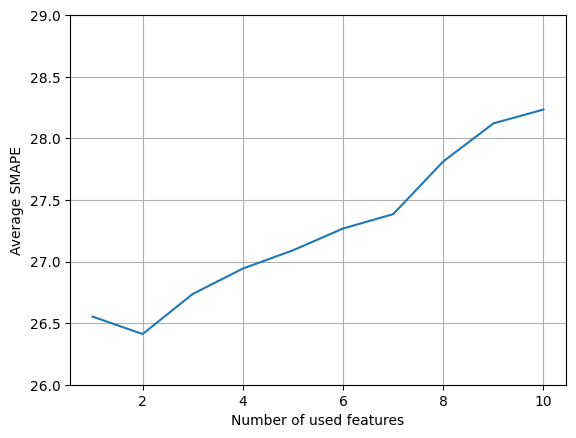

In [294]:
plt.plot(n_features, scores_list)
plt.ylim([26, 29])
plt.xlabel('Number of used features')
plt.ylabel('Average SMAPE')
plt.grid()

In [317]:
best_ord_features.append('naming_orig')
ord_features_best = ord_features[best_ord_features]
ord_features_best

,num_peaks,signal_entropy,naming_orig
0,87,5.100711,danish_atm_daily_0
1,57,4.574701,danish_atm_daily_1
2,79,5.294722,danish_atm_daily_10
3,87,5.210385,danish_atm_daily_100
4,51,4.689043,danish_atm_daily_101
...,...,...,...
866,206,5.944508,nn5_95
867,221,5.990598,nn5_96
868,224,5.929239,nn5_97
869,160,5.920899,nn5_98


### Tsfresh features selection

Now only features that are relevant for prediction of the best model by the minimum of SMAPE would be taken to further usage

In [303]:
df_merged_tsf = pd.merge(tsf_features, best_model_df)

encoder = LabelEncoder()
df_merged_tsf['model_id'] = encoder.fit_transform(df_merged_tsf[['model_name']])
features = tsf_features.drop('naming_orig', axis=1).columns

df_merged_tsf_train = df_merged_tsf[df_merged_tsf['naming_orig'].isin(list(Train_df))]

y_train = df_merged_tsf_train['model_id'] # labels of the best model for each time series
x_train = df_merged_tsf_train[features] # all tsfresh features for each time-series

Table that shows number of models for which each feature are relevant

In [304]:
feature_relevance = tsf.feature_selection.relevance.calculate_relevance_table(x_train, y_train, ml_task='classification', multiclass=True)
feature_relevance.head(10)

,feature,type,p_value_12,relevant_12,p_value_17,relevant_17,p_value_7,relevant_7,p_value_16,relevant_16,...,p_value_14,relevant_14,p_value_15,relevant_15,p_value_2,relevant_2,p_value_6,relevant_6,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,
value__abs_energy,value__abs_energy,real,0.692737,False,0.303314,False,0.413348,False,0.352315,False,...,0.620874,False,0.267452,False,0.507539,False,0.767328,False,2,True
value__absolute_maximum,value__absolute_maximum,real,0.560036,False,0.319566,False,0.383095,False,0.395672,False,...,0.307641,False,0.618704,False,0.893662,False,0.963077,False,2,True
value__absolute_sum_of_changes,value__absolute_sum_of_changes,real,0.907334,False,0.094673,False,0.197144,False,0.160547,False,...,0.892902,False,0.234806,False,0.614680,False,0.727688,False,2,True
"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""mean""__maxl...",real,0.003403,False,0.490623,False,0.866794,False,0.732292,False,...,0.113706,False,0.024624,False,0.756556,False,0.515619,False,2,True
"value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__ma...",real,0.000080,False,0.110871,False,0.791991,False,0.958972,False,...,0.767304,False,0.068216,False,0.556044,False,0.528704,False,2,True
"value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxla...",real,0.000013,True,0.018086,False,0.265612,False,0.867294,False,...,0.316602,False,0.263072,False,0.093901,False,0.408105,False,3,True
"value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","value__agg_linear_trend__attr_""intercept""__chu...",real,0.784929,False,0.330415,False,0.178141,False,0.669969,False,...,0.050111,False,0.033608,False,0.594833,False,0.779654,False,2,True
"value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","value__agg_linear_trend__attr_""intercept""__chu...",real,0.844751,False,0.428752,False,0.244923,False,0.654176,False,...,0.013076,False,0.020971,False,0.471799,False,0.991970,False,2,True
"value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","value__agg_linear_trend__attr_""intercept""__chu...",real,0.647321,False,0.816702,False,0.638933,False,0.602190,False,...,0.009759,False,0.187799,False,0.124539,False,0.892715,False,2,True


Take features that are relevant for more than 2 model predictions (24 features)

In [305]:
n_significant = []
relevant_faetures = []

for i in range(max(feature_relevance['n_significant']) + 1):
    n_significant.append(i)
    relevant_faetures.append(len(feature_relevance[feature_relevance['n_significant'] > i]['feature'].to_list()))

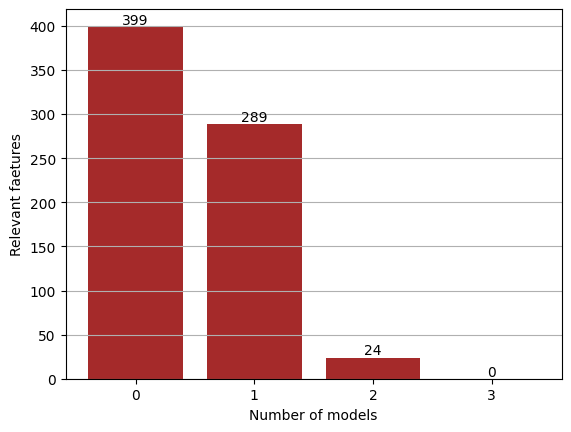

In [401]:
bar = plt.bar([str(x) for x in n_significant], relevant_faetures, color='brown')
plt.bar_label(bar)
plt.xlabel('Number of models')
plt.ylabel('Relevant faetures')
plt.grid(axis='y')

In [309]:
relevant_features = feature_relevance[feature_relevance['n_significant'] > 2]['feature'].to_list()
relevant_features.append('naming_orig')
tsf_features = tsf_features[relevant_features]
tsf_features.shape

(871, 25)

### Choosing the best feature pools

In [326]:
feature_pools = {'tsf': tsf_features,
                 'catch22': catch22_features,
                 'ordinary': ord_features,
                 'tsf + catch22': pd.merge(tsf_features, catch22_features),
                 'ord_best + catch22': pd.merge(ord_features_best, catch22_features),
                 'tsf + ord_best': pd.merge(ord_features_best, tsf_features),
                 'tsf + ord_best + catch22': pd.merge(pd.merge(ord_features_best, catch22_features), tsf_features)}

In [335]:
cv = 10
pools_scores = []
for feature_pool_name, features in feature_pools.items():

    df_merged = pd.merge(features, best_model_df)

    encoder = LabelEncoder()
    df_merged['model_id'] = encoder.fit_transform(df_merged[['model_name']])
    features = features.drop('naming_orig', axis=1).columns

    df_merged_train = df_merged[df_merged['naming_orig'].isin(list(Train_df))]

    scores = []

    X_train = df_merged_train.drop(['model_id', 'model_name'], axis=1)
    y_train = df_merged_train['model_id']

    for i in range(cv):
        X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=i)
    
        clf = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth=5)
        clf.fit(X_train_cv.drop('naming_orig', axis=1), y_train_cv)
        y_pred = clf.predict(X_val_cv.drop('naming_orig', axis=1))

        errors = 0
        sum = 0
        for series, model_id in zip(X_val_cv['naming_orig'].to_list(), y_pred):
            try:
                sum+=df[(df['naming_orig'] == series)&(df['model_name'] == encoder.classes_[model_id])]['SMAPE'].to_list()[0]
            except IndexError:
                errors+=1

        
        scores.append(sum/(X_val_cv.shape[0] - errors))

    pools_scores.append(np.mean(scores))

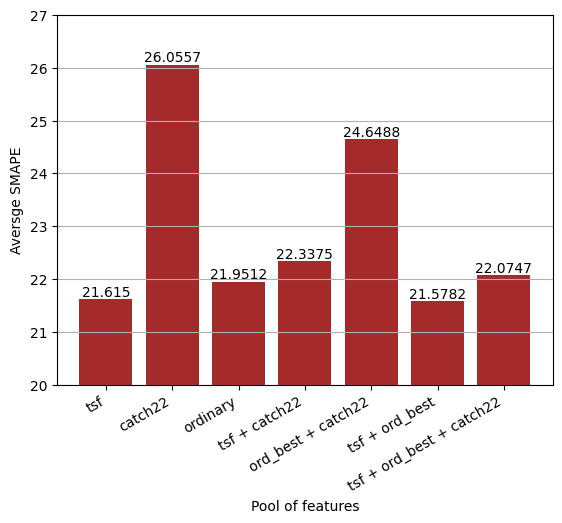

In [336]:
bar_1 = plt.bar(list(feature_pools.keys()), pools_scores, color='brown')
plt.xticks(rotation=30, ha='right')
plt.bar_label(bar_1)
plt.xlabel('Pool of features')
plt.ylabel('Aversge SMAPE')
plt.ylim([20, 27])
plt.grid(axis='y')

In [331]:
selected_features = pd.merge(ord_features_best, tsf_features)

## Download .csv files with different features

In [332]:
all_features.to_csv('All_features.csv')
tsf_features.to_csv('Tsfresh_features')
catch22_features.to_csv('Catch22_features.csv')
ord_features.to_csv('Ordinary_features.csv')
selected_features.to_csv('Selected_features')